In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import function
from sklearn.preprocessing import MinMaxScaler

In [2]:
df_origin = pd.read_excel('../VisitorEntrancesV3.xlsx')

In [3]:
df = df_origin[df_origin.Site_Name=='En Gedi']
df = function.remove_unique_one(df)
df = df.drop(df.filter(regex='Season').columns, axis=1)
df = df.drop(df.filter(regex='Exceeded').columns, axis=1)
df = df.drop(df.filter(regex='isHeatwave').columns, axis=1)
df = df.replace({True:1,False:0})

In [4]:
dfWithoutLastYearVisits = df.dropna().drop('last_year_visitors',axis=1)
dfLastYearVisits = df.dropna()

In [5]:
print(dfLastYearVisits.shape)
print(dfWithoutLastYearVisits.shape)

(1002, 8)
(1002, 7)


In [6]:
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from IPython.display import clear_output
from keras.regularizers import l2

In [7]:
dfWithoutLastYearVisits.sort_values('Date')
X = dfWithoutLastYearVisits.drop(['Israelis_Count'],axis=1)
y = dfWithoutLastYearVisits[['Date','Israelis_Count']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train.drop('Date',axis=1))
X_test_scaled = X_test_scaler.fit_transform(X_test.drop('Date',axis=1))
 
X_train_scaled


X_train_date = X_train.Date
y_train_date = y_train.Date
X_test_date = X_test.Date
y_test_date = y_test.Date

y_train.drop('Date',axis=1,inplace=True)
y_test.drop('Date',axis=1,inplace=True)

In [18]:
# create NN model
model = Sequential()
model.add(Dense(X_train_scaled.shape[1], input_dim=X_train_scaled.shape[1],activation='relu',activity_regularizer=l2(0.01)))
model.add(Dense(516,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(516,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
 

In [19]:
# Compiling the model
model.compile(metrics=['mae','accuracy'], optimizer='adam', loss = 'mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1 )
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=0 )
mcp = ModelCheckpoint(filepath='weightsEnGediWithoutLastYearVisits.h5', monitor='val_loss', verbose=1 , save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_scaled, y_train, shuffle=True, epochs=10000,callbacks=[es, rlr, mcp, tb],validation_split=0.2,batch_size=1)
clear_output(True)


Epoch 1/10000
633/640 [============================>.] - ETA: 0s - loss: 686100.7500 - mae: 609.4260 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 860816.81250, saving model to weightsEnGediWithoutLastYearVisits.h5
640/640 [==============================] - 4s 4ms/step - loss: 690000.2500 - mae: 611.7543 - accuracy: 0.0000e+00 - val_loss: 860816.8125 - val_mae: 802.1628 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10000
630/640 [============================>.] - ETA: 0s - loss: 521733.9062 - mae: 532.5592 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 860816.81250 to 655891.87500, saving model to weightsEnGediWithoutLastYearVisits.h5
640/640 [==============================] - 2s 4ms/step - loss: 519652.7500 - mae: 532.3209 - accuracy: 0.0000e+00 - val_loss: 655891.8750 - val_mae: 672.9418 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10000
637/640 [============================>.] - ETA: 0s - loss: 537408.2500 - mae: 538.5749 - accuracy: 0.0000e+00
Epoch 3: 

In [20]:
model.load_weights('weightsEnGediWithoutLastYearVisits.h5')

In [21]:
# model.save('Model En-Gedi without last year')

26/26 [==============================] - 0s 2ms/step

mae 491.6427941483058
rmse 677.1284675783805
std 719.3264043576573


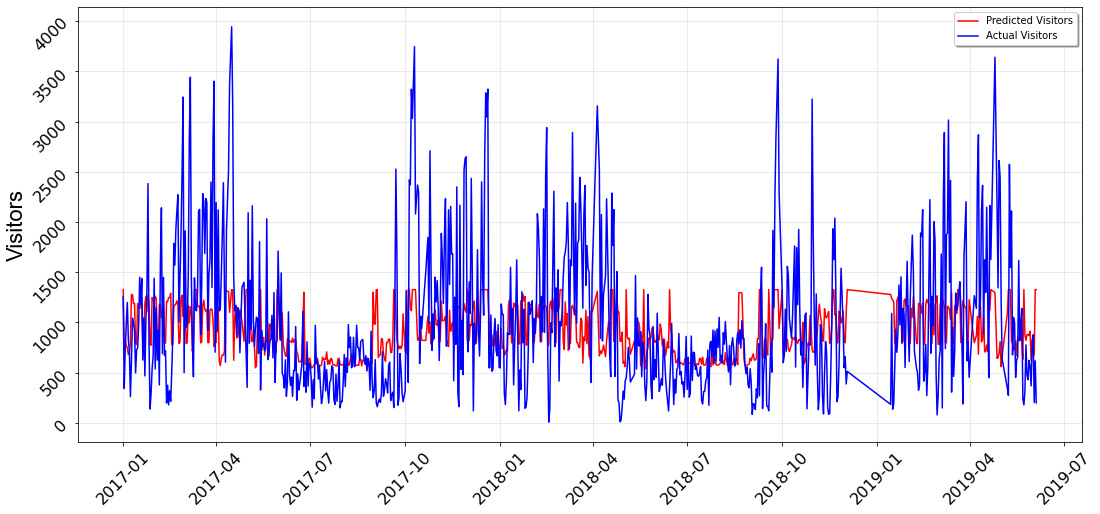

,Prediction,Actual
Date,,
2017-01-01,1326.769897,1257
2017-01-02,776.996704,342
2017-01-03,818.989075,746
2017-01-04,770.747681,991
2017-01-05,749.335449,1199
2017-01-06,681.774292,825
2017-01-07,701.364868,720
2017-01-08,793.822510,262
2017-01-09,1274.076782,621


In [22]:
prediction = model.predict(X_train_scaled)
prediction = prediction.reshape(len(X_train_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_train.values.T[0],
        },
    index=y_train_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

7/7 [==============================] - 0s 2ms/step

mae 440.2834087011233
rmse 623.8877939512751
std 690.7782847249603


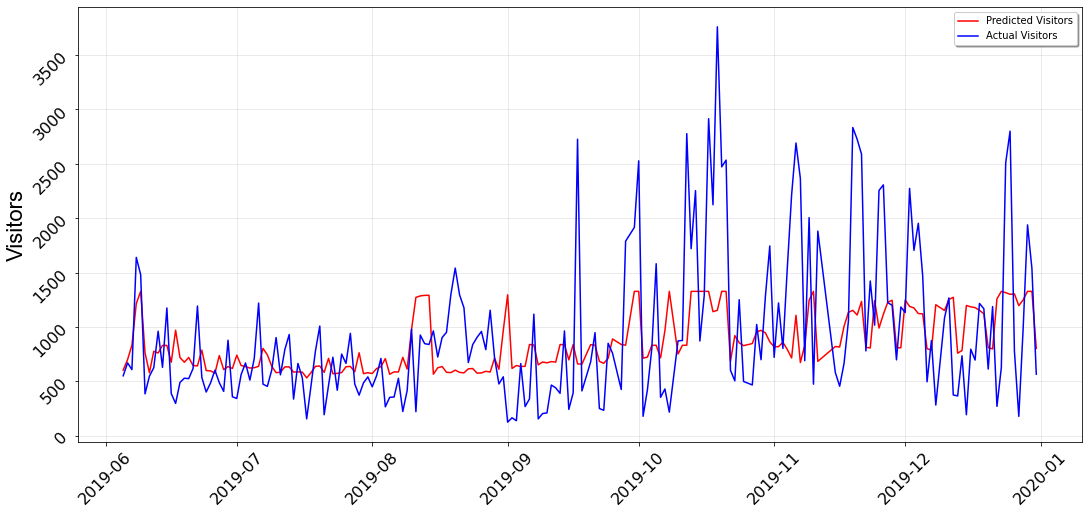

,Prediction,Actual
Date,,
2019-06-05,602.466064,550
2019-06-06,698.584961,669
2019-06-07,831.209473,607
2019-06-08,1214.843140,1639
2019-06-09,1326.769897,1480
2019-06-10,761.144775,384
2019-06-11,578.394775,546
2019-06-12,775.861938,625
2019-06-13,759.825562,960


In [23]:
prediction = model.predict(X_test_scaled)
prediction = prediction.reshape(len(X_test_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_test.values.T[0],
        },
    index=y_test_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

In [25]:
from lime_stability.stability import LimeTabularExplainerOvr

class_names=['Israelis_Count']

categorical_features = np.argwhere(
    np.array([len(set(X_train_scaled[:,x]))
    for x in range(X_train_scaled.shape[1])]) <= 2).flatten()

print(X_train_scaled.shape)
print(categorical_features.shape)
print(X_train_scaled.shape)

explainer = LimeTabularExplainerOvr(np.array(X_train_scaled),
 feature_names=X_train.drop('Date',axis=1).columns,
 class_names=class_names, 
 categorical_features=categorical_features, 
 verbose=True,
 mode='regression'
 )

i = np.random.randint(len(X_test_scaled))
print('index ', i, ':: Actual values = ', y_test.Israelis_Count.values[i])
print('index ', i, ':: Prediction values = ', prediction.tolist()[i])
exp = explainer.explain_instance((X_test_scaled[i]),model.predict,num_features=100)
exp.show_in_notebook(show_table=True)
function.outputLimeAsDf(exp)


(801, 5)
(3,)
(801, 5)
index  2 :: Actual values =  607
index  2 :: Prediction values =  831.20947265625
157/157 [==============================] - 0s 2ms/step
Intercept 1150.0325094157195
Prediction_local [745.44171424]
Right: 831.2095


,0
IsHoliday,405.121145
IsVacation,-214.757101
is weekend,-105.950955
Temperature,-87.154307
pm10,-21.121490
